In [225]:
import pandas as pd
import numpy as np

df = pd.read_csv('labeled_peak_windows.csv')
labels = df['LABEL']
df.drop(columns = ['Container_Well', 'LABEL'], inplace = True)

In [226]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
#k = 15, nonzero = 12

k = 13
nonzero = 10

kmeans_model = KMeans(n_clusters = k, init = 'k-means++').fit(df)
dictionary = kmeans_model.cluster_centers_

C:\Users\kshu\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [227]:
from sklearn.decomposition import SparseCoder
coder = SparseCoder(
            dictionary=dictionary,
            transform_n_nonzero_coefs=nonzero, 
            transform_alpha=None,
            transform_algorithm="omp",
        )


x = coder.transform(df)

C:\Users\kshu\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SparseCoder was fitted without feature names
  warnings.warn(


In [228]:
#function to train and evaluate models. Appends to a table and returns the table

from sklearn.metrics import matthews_corrcoef,accuracy_score,roc_curve,auc
from sklearn.preprocessing import LabelEncoder  

def run_model(clf, clf_name, X_train, X_test, y_train, y_test, resultsTable):
    
    #train model
    clf = clf.fit(X_train, y_train)
    
    # Compute some metrics
    y_pred = clf.predict(X_test)
    le = LabelEncoder()
    y_test_num = le.fit_transform(y_test)
    y_pred_num = le.fit_transform(y_pred)
    fpr, tpr, _ = roc_curve(y_test_num, y_pred_num,pos_label=1)

    # Store the results in the table
    resultsTable.add_row([clf_name, str(round(accuracy_score(y_test, y_pred),2)), 
                          str(round(matthews_corrcoef(y_test, y_pred),2)), 
                          str(round(auc(fpr, tpr),2))])
    return resultsTable
    
    

Running models on only the ten representation numbers for each trace

+---------------------+----------+------+------+
|        Model        | Accuracy | MCC  | AUC  |
+---------------------+----------+------+------+
|    Decision Tree    |   0.88   | 0.49 | 0.63 |
|    Random Forest    |   0.94   | 0.77 | 0.69 |
| Logistic Regression |   0.87   | 0.27 | 0.45 |
|     Naive Bayes     |   0.34   | 0.35 | 0.69 |
|         KNN         |   0.93   | 0.72 | 0.67 |
+---------------------+----------+------+------+


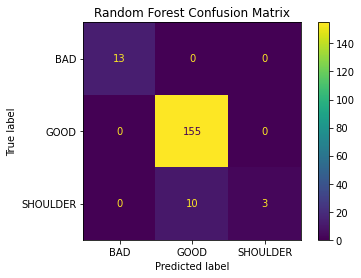

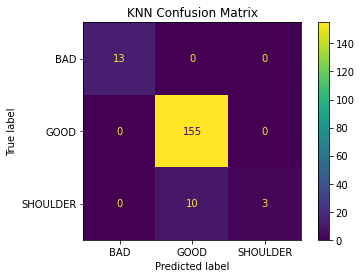

In [229]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable

resultsTable = PrettyTable()
resultsTable.field_names = ["Model","Accuracy", "MCC", "AUC"]

#prepare data
X = pd.DataFrame(x) #this is the matrix with the ten representation numbers
y = labels


#necessary fro KNN, not Naive Bayes
X = StandardScaler().fit_transform(X)

# Split the data into training and test partitions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Train a Decision tree
clf = DecisionTreeClassifier()
resultsTable = run_model(clf,'Decision Tree',X_train, X_test, y_train, y_test,resultsTable)
# Plot the confusion matrix


# Train a Random Forest with 100 trees
clf = RandomForestClassifier(n_estimators=100)
resultsTable = run_model(clf,'Random Forest',X_train, X_test, y_train, y_test,resultsTable)
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test) 
disp.ax_.set_title('Random Forest Confusion Matrix')


# Now compare to other methods
resultsTable = run_model(LogisticRegression(),'Logistic Regression',X_train, X_test, y_train, y_test,resultsTable)
resultsTable = run_model(GaussianNB(),'Naive Bayes',X_train, X_test, y_train, y_test,resultsTable)
resultsTable = run_model(KNeighborsClassifier(3, weights="uniform"),'KNN',X_train, X_test, y_train, y_test,resultsTable)
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test) 
disp.ax_.set_title('KNN Confusion Matrix')

print(resultsTable)